#### (2-15-2020) First tried git control. Apply drop='first' in OneHotEncoder and tries on Logistic regression. 

In [1]:
%autosave 0

Autosave disabled


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from scipy.stats import uniform, norm
import glob
%matplotlib inline

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, \
cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
import sklearn
plt.ion()

In [4]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)

## Data visualization

In [5]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
sns.set(style='darkgrid')
colors = ['darkred', 'darkseagreen']

### 1. Visualize the survival chance of persons with different fare

In [8]:
data_train[data_train['Fare'] > 300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


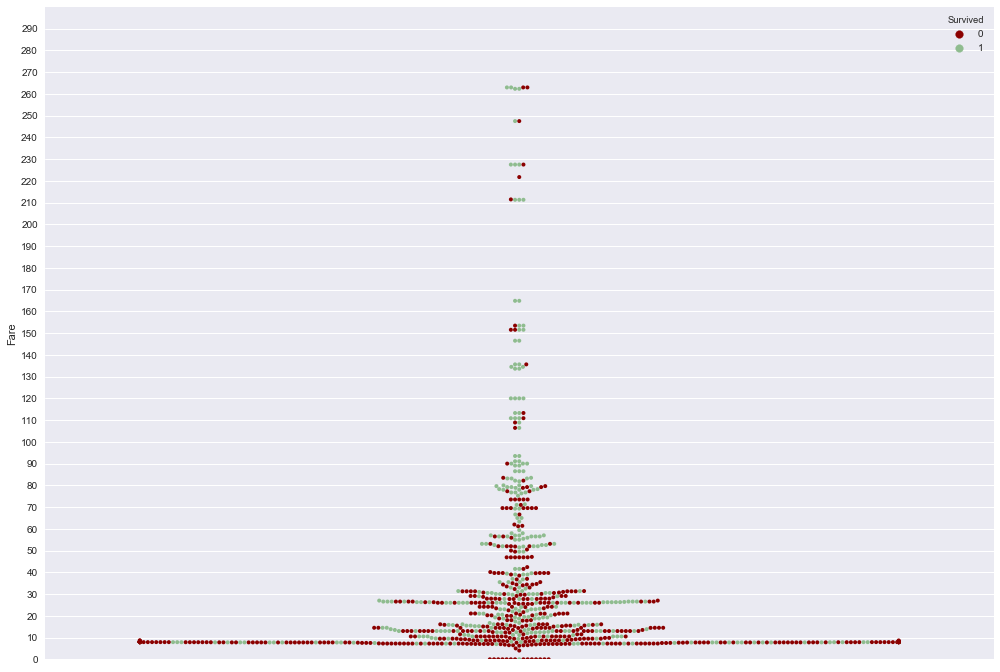

In [9]:
fig, ax = plt.subplots(figsize=(17,12))
ax.set_ylim(0, 300)
ax.set_yticks(np.arange(0, 300, 10))
sns.swarmplot(y=data_train['Fare'], x=[""]*len(data_train), size=4, 
              hue=data_train['Survived'], palette=colors)

#### The plot above shows that persons with fare above 75 had a relatively good chance of survival, and those with fare below about 10.5 the chance was quite bad, and those with fare in between seems to have a chance somewhere in the middle. 

### 2. Add 'SibSp' and 'Parch' together and visualize the chance of survival

In [10]:
df_try = data_train.copy()
df_try['SibSp_Parch'] = df_try['SibSp'] + df_try['Parch']
df_try.groupby('SibSp_Parch')['Survived'].value_counts()

SibSp_Parch  Survived
0            0           374
             1           163
1            1            89
             0            72
2            1            59
             0            43
3            1            21
             0             8
4            0            12
             1             3
5            0            19
             1             3
6            0             8
             1             4
7            0             6
10           0             7
Name: Survived, dtype: int64

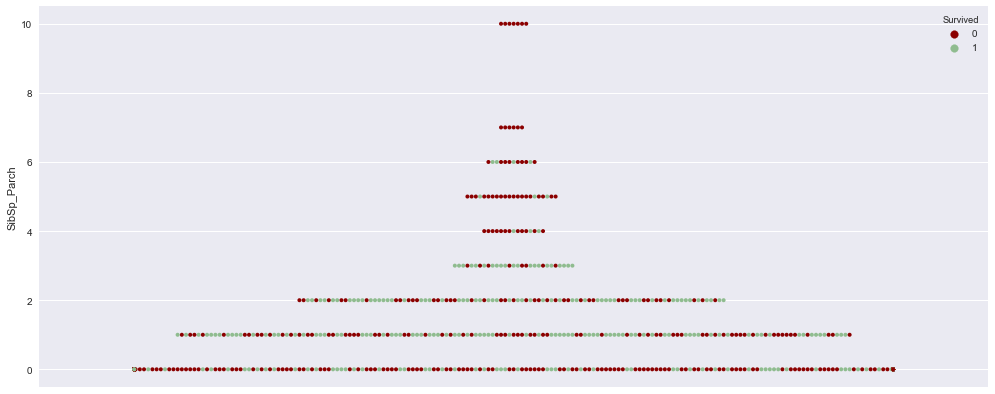

In [11]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.swarmplot(y=df_try['SibSp_Parch'], x=[""]*len(df_try), size=4, hue=df_try['Survived'], 
              palette=colors)

#### The plot above shows that persons with 4 relatives or above had a relatively small chance of survival, and the same is true (to a lesser extent) with persons who traveled alone with 0 relatives. In contrast, persons with 1 to 3 relatives had a better chance of survival.   

### 3. Visualize chance of survival in plots combining sex, age, and Pclass

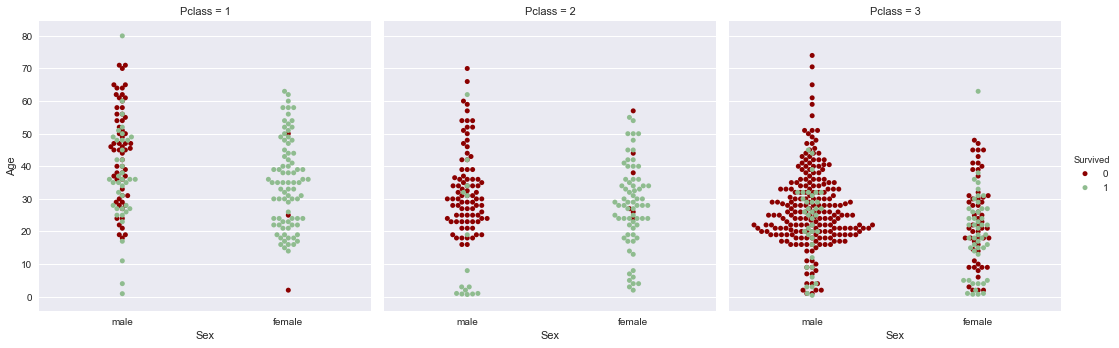

In [12]:
g1 = sns.FacetGrid(data_train, col='Pclass', hue='Survived', palette=colors, size=5, aspect=1)
g1 = g1.map(sns.swarmplot, 'Sex', 'Age', order=['male', 'female'], size=5)
g1.add_legend()

#### It can be seen from the plot above that male with age less than about 12 years old had a better chance of survival compared to male older than this age. We will later create a new feature to reflect this.

In [13]:
mask_master = pd.Series('Master' in i for i in data_train['Name'])
data_train[mask_master].sort_values('Age', ascending=False).head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
125,126,1,3,"Nicola-Yarred, Master. Elias",male,12.0,1,0,2651,11.2417,NaN,C
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
165,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
489,490,1,3,"Coutts, Master. Eden Leslie ""Neville""",male,9.0,1,1,C.A. 37671,15.9000,NaN,S
549,550,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.7500,NaN,S
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,NaN,Q


#### From the table above it can be seen that if a person has 'Master' in 'Name' then this person is a male with age less than or equal to 12 years old.

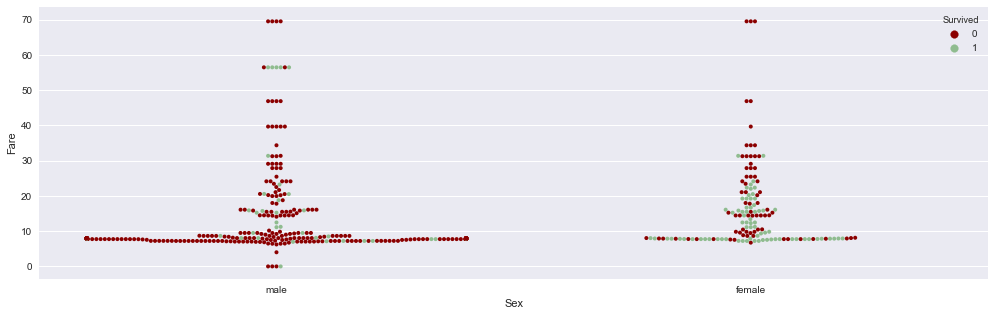

In [14]:
fig, ax = plt.subplots(figsize=(17, 5))
sns.swarmplot(x='Sex', y='Fare', data=data_train[data_train['Pclass']==3], size=4, 
              hue='Survived', palette=colors)

#### It can be seen from the plot above that female in Pclass 3 with fare greater than about 24 almost all did not make it. We will also later create a new feature to reflect this.

## Data cleaning and preprocessing

In [15]:
y = data_train['Survived']
X = data_train.drop('Survived', axis=1)
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
def combine_Sib_Par(df):
    """Sum the two columns SibSp and Parch together."""
    df['SibSp_Parch'] = df['SibSp'] + df['Parch']

def add_name_master_feature(df):
    """Create a new feature: if Master in Name, then Yes, otherwise, No."""
    mask_master = pd.Series('Master' in i for i in df['Name'])
    df1 = df['Name'].mask(mask_master, 'Yes')
    df['Name_Master'] = df1.where(mask_master, 'No')    
    
def add_female_pclass_3_high_fare_feature(df):
    """Create a new feature: if female, in Pclass 3, and Fare > 24, Yes, otherwise, No."""
    df_temp = df[((df['Pclass']==3) & (df['Sex']=='female')) & (df['Fare']>24.)]
    mask = df.index.isin(df_temp.index)
    df['Fem_Hfare_Pcl3'] = pd.Series(range(df.shape[0])).mask(mask, 'Yes')
    df['Fem_Hfare_Pcl3'] = df['Fem_Hfare_Pcl3'].where(mask, 'No')

def drop_feature(df):
    df.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], \
            axis=1, inplace=True)
    
def fill_feature(df):
    """Fill all NaN values."""
    df['Pclass'] = df['Pclass'].fillna(-1)
    df['Sex'] = df['Sex'].fillna('Unknown')
    df['SibSp_Parch'] = df['SibSp_Parch'].fillna(-1)
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

def bin_fare_and_SibSpParch(df):
    """Bin Fare and SibSp_Parch based on previous visualization results."""
    bins = (0, 10.5, 75, 1500)
    group_names = ['10.5_below', '10.5_to_75', '75_above']
    df['Fare'] = pd.cut(df['Fare'], bins, labels=group_names, right=False)
    
    bins = (-1, -0.1, 0.1, 4, 50)
    group_names = ['Unknown', '0', '4_below', '4_above']
    df['SibSp_Parch'] = pd.cut(df['SibSp_Parch'], bins, labels=group_names, right=False)

def data_transform(df):
    combine_Sib_Par(df)
    add_name_master_feature(df)
    add_female_pclass_3_high_fare_feature(df)
    drop_feature(df)
    fill_feature(df)
    bin_fare_and_SibSpParch(df)

In [18]:
data_transform(X)

In [19]:
X.head(10)

,Pclass,Sex,Fare,SibSp_Parch,Name_Master,Fem_Hfare_Pcl3
0,3,male,10.5_below,4_below,No,No
1,1,female,10.5_to_75,4_below,No,No
2,3,female,10.5_below,0,No,No
3,1,female,10.5_to_75,4_below,No,No
4,3,male,10.5_below,0,No,No
5,3,male,10.5_below,0,No,No
6,1,male,10.5_to_75,0,No,No
7,3,male,10.5_to_75,4_above,Yes,No
8,3,female,10.5_to_75,4_below,No,No
9,2,female,10.5_to_75,4_below,No,No


In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass            891 non-null int64
Sex               891 non-null object
Fare              891 non-null category
SibSp_Parch       891 non-null category
Name_Master       891 non-null object
Fem_Hfare_Pcl3    891 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 30.0+ KB


In [21]:
ohe = OneHotEncoder(drop='first')
X_1 = ohe.fit_transform(X).toarray()
list(X_1)[:10] 

[array([0., 1., 1., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 1., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 1., 0., 0.]),
 array([0., 1., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0., 0., 0.]),
 array([0., 1., 1., 1., 0., 1., 0., 1., 0.]),
 array([0., 1., 0., 1., 0., 0., 1., 0., 0.]),
 array([1., 0., 0., 1., 0., 0., 1., 0., 0.])]

In [22]:
ohe.categories_

[array([1, 2, 3], dtype=int64),
 array(['female', 'male'], dtype=object),
 array(['10.5_below', '10.5_to_75', '75_above'], dtype=object),
 array(['0', '4_above', '4_below'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [23]:
x_ax = ohe.get_feature_names(['Pclass', 'Sex', 'Fare', 'SibSp_Parch', 'Name_Master', 
                              'Fem_Hfare_Pcl3'])
x_ax

array(['Pclass_2', 'Pclass_3', 'Sex_male', 'Fare_10.5_to_75',
       'Fare_75_above', 'SibSp_Parch_4_above', 'SibSp_Parch_4_below',
       'Name_Master_Yes', 'Fem_Hfare_Pcl3_Yes'], dtype=object)

In [24]:
# Create a DataFrame for correlation plot
X_1_frame = pd.DataFrame(X_1, columns=x_ax)
X_1_frame.head()

,Pclass_2,Pclass_3,Sex_male,Fare_10.5_to_75,Fare_75_above,SibSp_Parch_4_above,SibSp_Parch_4_below,Name_Master_Yes,Fem_Hfare_Pcl3_Yes
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


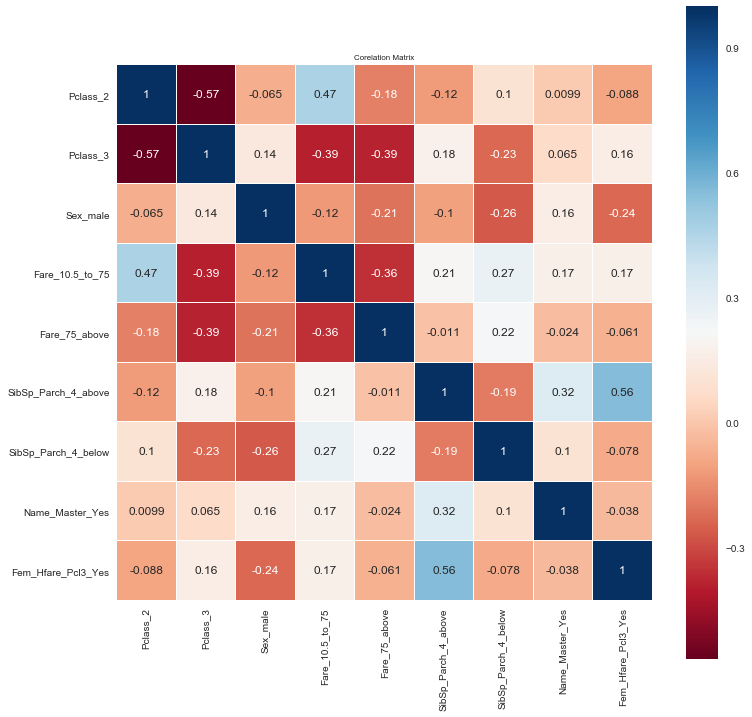

In [25]:
plt.figure(figsize=(12, 12))
plt.title('Corelation Matrix', size=8)
sns.heatmap(X_1_frame.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=plt.cm.RdBu, 
            linecolor='white', annot=True)
plt.show()

## Data training and parameter tuning

In [26]:
# define a cv splitter
cv_splitter = StratifiedKFold(n_splits=5, random_state=42)

### 1. First Model: Logistic Regressionfrom 


In [27]:
logis = LogisticRegression(solver='liblinear', random_state=42)
C_param = sorted(10**np.random.uniform(-2, 0, size=100))  # log-uniform distrbution from 0.01 to 1
# Since if there are multiple parameter combinations rank first, GridSearchCV will choose the
# first encountered one as the best result, sort the array so the smallest possible C can be 
# picked. 
parameter_grid = {
                'C': C_param,
                'class_weight': ['balanced', None]
                }
grid_logis = GridSearchCV(logis, parameter_grid, cv=cv_splitter, refit=True)
grid_logis.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=Fal...
                               0.02792948368794934, 0.02893195945890884,
                               0.03567413908365859, 0.03795841908865564,
                               0.03980691178186232, 0.0425033781997907,
                               0.04615599762495031, 0.060952860244286367,
                

In [28]:
logis_best_param = grid_logis.best_params_  
logis_best_param
# best parameter values to be used in the stack model

{'C': 0.5885323539148449, 'class_weight': None}

In [27]:
# logis_best_param = grid_logis.best_params_  
# logis_best_param
# # best parameter values to be used in the stack model

{'C': 0.31627732156176225, 'class_weight': None}

In [29]:
results = pd.DataFrame(grid_logis.cv_results_)
results.iloc[:,4:].sort_values('rank_test_score')

,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
199,0.875257,None,"{'C': 0.8752568966137482, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
197,0.774028,None,"{'C': 0.7740276198242042, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
195,0.725487,None,"{'C': 0.7254869345272917, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
193,0.659917,None,"{'C': 0.659916850851133, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
191,0.633456,None,"{'C': 0.633455592484765, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
189,0.629742,None,"{'C': 0.6297415789478888, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
187,0.588532,None,"{'C': 0.5885323539148449, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.853107,0.824916,0.016077,1
175,0.416467,None,"{'C': 0.4164666802765328, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.836158,0.821549,0.010694,8
173,0.393472,None,"{'C': 0.39347209966083935, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.836158,0.821549,0.010694,8
155,0.301321,None,"{'C': 0.301320507322342, 'class_weight': None}",0.821229,0.826816,0.820225,0.803371,0.836158,0.821549,0.010694,8


In [28]:
# results = pd.DataFrame(grid_logis.cv_results_)
# results.iloc[:,4:].sort_values('rank_test_score')

,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
199,0.978386,None,"{'C': 0.9783856697298245, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
143,0.316277,None,"{'C': 0.31627732156176225, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
145,0.318621,None,"{'C': 0.3186213683660766, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
147,0.321341,None,"{'C': 0.3213409591674894, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
151,0.353986,None,"{'C': 0.353986049730384, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
153,0.360239,None,"{'C': 0.3602386549841044, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
177,0.767987,None,"{'C': 0.7679874621990408, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
179,0.771862,None,"{'C': 0.7718616277185719, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
181,0.786591,None,"{'C': 0.7865914292345481, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
149,0.341769,None,"{'C': 0.3417694676350401, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1


In [30]:
x_ax = ohe.get_feature_names(['Pclass', 'Sex', 'Fare', 'SibSp_Parch', 'Name_Master', 
                              'Fem_Hfare_Pcl3'])
x_ax

array(['Pclass_2', 'Pclass_3', 'Sex_male', 'Fare_10.5_to_75',
       'Fare_75_above', 'SibSp_Parch_4_above', 'SibSp_Parch_4_below',
       'Name_Master_Yes', 'Fem_Hfare_Pcl3_Yes'], dtype=object)

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x000002AD04779DD8>>

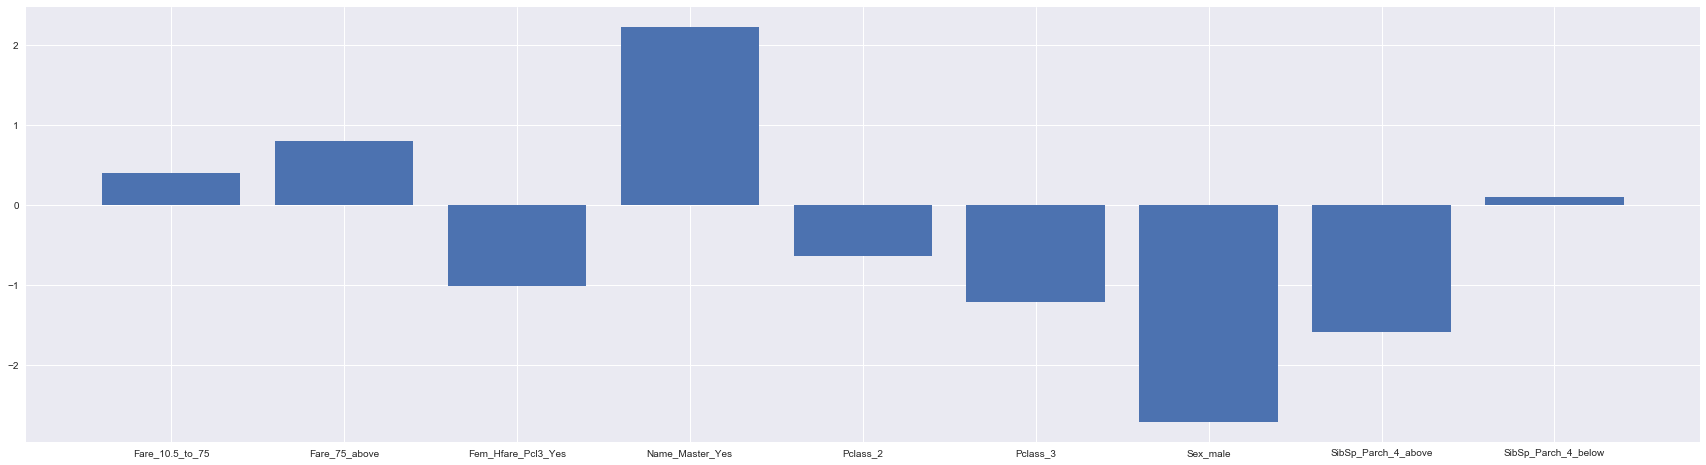

In [31]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(x_ax, grid_logis.best_estimator_.coef_[0])
ax.grid

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x00000256D38B31D0>>

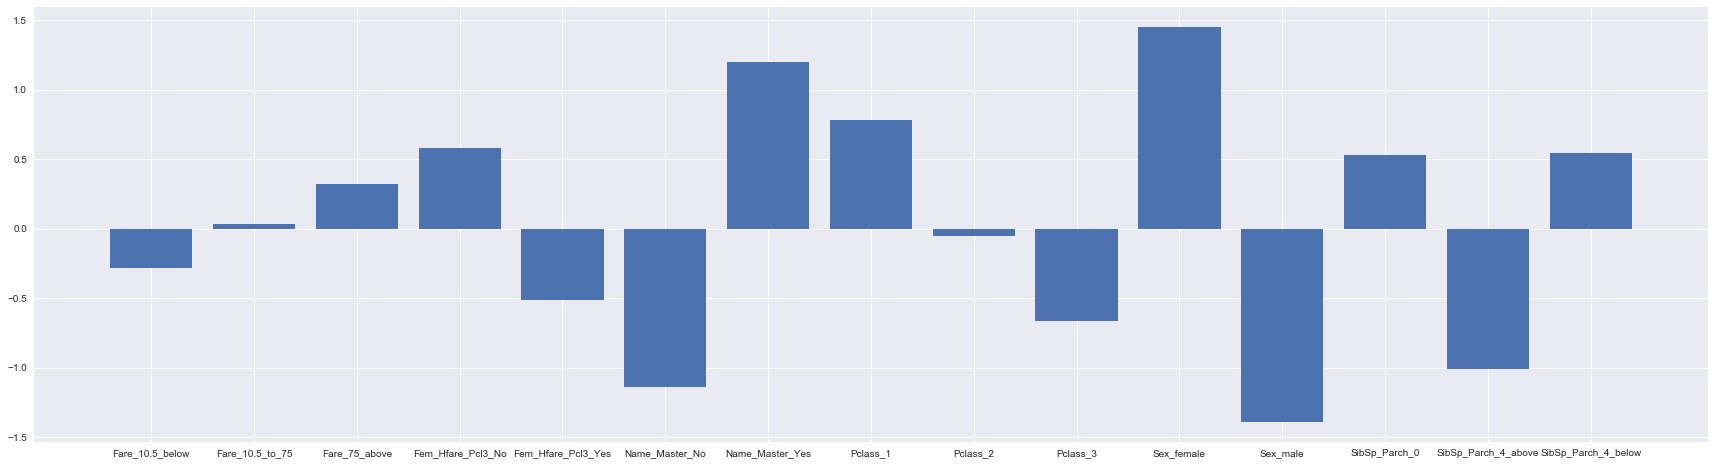

In [30]:
# fig, ax = plt.subplots(figsize=(30,8))
# ax.bar(x_ax, grid_logis.best_estimator_.coef_[0])
# ax.grid

In [32]:
scores_logis = cross_val_score(grid_logis.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_logis)
print('Mean (logis): '+str(scores_logis.mean()))
print('SD (logis): '+str(scores_logis.std()))

[0.82122905 0.82681564 0.82022472 0.80337079 0.85310734]
Mean (logis): 0.8249495085976353
SD (logis): 0.016113056062031277


In [31]:
# scores_logis = cross_val_score(grid_logis.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
# print(scores_logis)
# print('Mean (logis): '+str(scores_logis.mean()))
# print('SD (logis): '+str(scores_logis.std()))

[0.82122905 0.82681564 0.8258427  0.80337079 0.86440678]
Mean (logis): 0.828332991108903
SD (logis): 0.019916825888839272


## Test data preprocessing

In [33]:
data_test = pd.read_csv('test.csv')
passenger_id = data_test['PassengerId']
num_row_test = data_test.shape[0]
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [34]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [35]:
data_transform(data_test)
data_test.head()

,Pclass,Sex,Fare,SibSp_Parch,Name_Master,Fem_Hfare_Pcl3
0,3,male,10.5_below,0,No,No
1,3,female,10.5_below,4_below,No,No
2,2,male,10.5_below,0,No,No
3,3,male,10.5_below,0,No,No
4,3,female,10.5_to_75,4_below,No,No


In [36]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass            418 non-null int64
Sex               418 non-null object
Fare              418 non-null category
SibSp_Parch       418 non-null category
Name_Master       418 non-null object
Fem_Hfare_Pcl3    418 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 14.2+ KB


In [37]:
data_test['Fare'].value_counts()

10.5_to_75    215
10.5_below    155
75_above       48
Name: Fare, dtype: int64

In [38]:
X_test = ohe.transform(data_test).toarray()
list(X_test)[:10]

[array([0., 1., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 1., 0., 0.]),
 array([1., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 1., 0., 0., 1., 0., 0.]),
 array([0., 1., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 1., 1., 0., 0., 1., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 1., 1., 0., 0., 1., 0., 0.])]

## Model Predictions

### 1. Logistic regression

In [42]:
y_test_predict_logis = grid_logis.predict(X_test)
submission_logis_5 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_logis})

existing_file = glob.glob('submission_logis_5.csv')
assert (not existing_file), 'File already existed.'
submission_logis_5.to_csv('submission_logis_5.csv', index=False)
# (This submission got a public score of 0.794)